Name: Shoieb Ur Rahman Thayal

Project Title: Tuberculosis Detection through Chest X-Ray images using CNNs

Dataset Link: https://drive.google.com/drive/folders/1ZHfp9iigHH983vmNnKWJhfuH0zk5d2nY?usp=sharing



The pupose for this project was to find a reliable method of using a machine learning model to confidently detect for the presence of Tuberculosis in a given Chest X-Ray image.

This is the implementation of the proposed project which uses the below imported modules and trains on the dataset uploaded to Google Drive. The dataset is accessed by first mounting to drive.

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from collections import Counter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings("ignore")


# 1. Data Preprocessing

Data preprocessing is the crucial first step in building a machine learning model. It involves performing all the necessage actions to make the data ready to be trained upon. The dataset used in this project consists of publicly sourced X-ray images. The image data is already resized to a uniform dimension of 512x512.

First we load the datset from GoogleDrive and perform preliminary visualization to understand the classes and distrubution of our available data.

**NOTE:** The below cell is for the use of Google Drive and Google Colab. Due to the limited processing space and speed of Google Colab, I was facing issues in training the model within reasonable time. Hence I have opted to run this implementation on my local runtime environment skipping the the execution of the below cell.

In [ ]:
# FOR GOOGLE COLAB RUN
from google.colab import drive
drive.mount('/content/drive')

# Paths to the dataset
data_path_normal = '/content/drive/MyDrive/ML_Project/Normal'
data_path_tb = '/content/drive/MyDrive/ML_Project/Tuberculosis'

# Load all image paths
tb_images = [os.path.join(data_path_tb, fname) for fname in os.listdir(data_path_tb) if fname.endswith('.png')]
normal_images = [os.path.join(data_path_normal, fname) for fname in os.listdir(data_path_normal) if fname.endswith('.png')]
all_images = tb_images + normal_images
labels = [1] * len(tb_images) + [0] * len(normal_images)


In [ ]:
# FOR LOCAL RUNTIME

# Paths to the dataset
data_path_normal = 'Normal'
data_path_tb = 'Tuberculosis'

# Load all image paths
tb_images = [os.path.join(data_path_tb, fname) for fname in os.listdir(data_path_tb) if fname.endswith('.png')]
normal_images = [os.path.join(data_path_normal, fname) for fname in os.listdir(data_path_normal) if fname.endswith('.png')]
all_images = tb_images + normal_images
labels = [1] * len(tb_images) + [0] * len(normal_images)


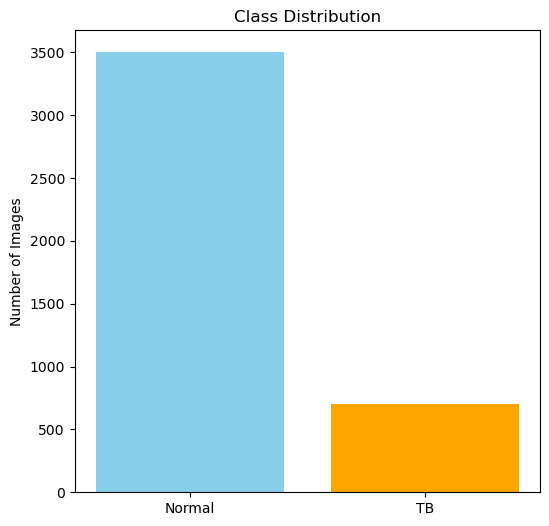

In [ ]:

# Class distribution
class_counts = Counter(labels)
classes = ['Normal', 'TB']
counts = [class_counts[0], class_counts[1]]

plt.figure(figsize=(6, 6))
plt.bar(classes, counts, color=['skyblue', 'orange'])
plt.title('Class Distribution')
plt.ylabel('Number of Images')
plt.show()


Due to a lack of publicly available data for TB positive X-ray images, there is a major class imbalance in the dataset. There are 3500 images of class 0 (normal) and 700 images of class 1 (TB positive). But with the help of some clever preprocessing steps, we can still reduce impact of this class imbalance.

In this project, two steps will be taken to handle this class imbalance. The first is to undersample the majority class. Here this is done by randomly selection the required number of images from the larger set. This brings the ratio of TB positive data to normal data down to 1:2.

In [ ]:
# Undersample the normal class
np.random.seed(42)  # For reproducibility
undersampled_normal_images = np.random.choice(normal_images, size=1400, replace=False)

# Updating combined image list
all_images = tb_images + list(undersampled_normal_images)
labels = [1] * len(tb_images) + [0] * len(undersampled_normal_images)

# Shuffle the dataset
dataset = list(zip(all_images, labels))
np.random.shuffle(dataset)
all_images, labels = zip(*dataset)


Next, class weights are used to balance the data further. The class weights are calculated using the compute_class_weight() function from the sklearn module.

In [ ]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = dict(enumerate(class_weights))
weights = [class_weights[0], class_weights[1]]
print("Class Weights:", class_weights)


Class Weights: {0: 0.75, 1: 1.5}


Here are two graphs visualizing the partially undersampled dataset and class weights.

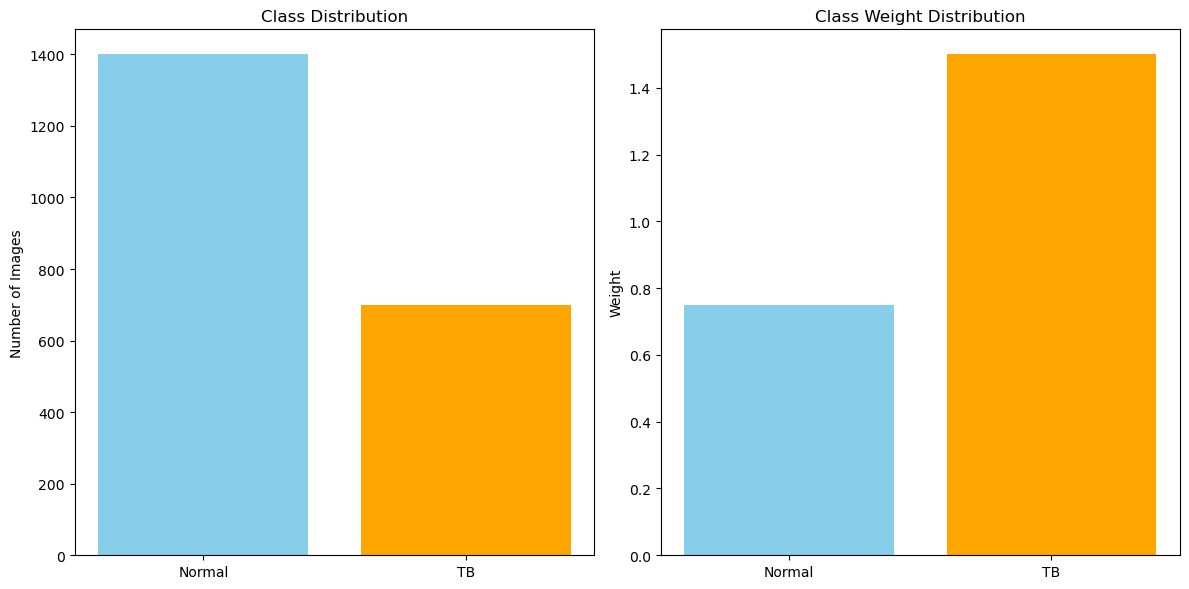

In [ ]:
# Visualising
class_counts = Counter(labels)
classes = ['Normal', 'TB']
counts = [class_counts[0], class_counts[1]]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].bar(classes, counts, color=['skyblue', 'orange'])
axes[0].set_title('Class Distribution')
axes[0].set_ylabel('Number of Images')

# Plot Class Weight Distribution
axes[1].bar(classes, weights, color=['skyblue', 'orange'])
axes[1].set_title('Class Weight Distribution')
axes[1].set_ylabel('Weight')

# Adjust layout
plt.tight_layout()
plt.show()

Next step in the preprocessing is to split the data into training, validation and testing sets. The training and validation sets are used during the training phase and the testing set is only used to finally test the performance of the model on unseen data.

In this project, a train-test split of 70-15-15 is used. This means that 70% of the data is used as the training set, 15% as the validation set and the remaining 15% as the validation set.

In [ ]:
# Spliting into train, validation, and test sets (70-15-15 split)

# Split into train and test+val first
train_images, test_val_images, train_labels, test_val_labels = train_test_split(
    all_images, labels, test_size=0.3, random_state=42, stratify=labels
)

# Split test+val into test and validation sets
test_images, val_images, test_labels, val_labels = train_test_split(
    test_val_images, test_val_labels, test_size=0.5, random_state=42, stratify=test_val_labels
)

# Convert labels to strings for compatibility with ImageDataGenerator
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))



Lastly, ImageDataGenerator is being used here to artificially increase the diversity of the dataset and potentially increase the generalizablity of the model.

In [ ]:
# ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.15
)

# Creating the data generators
train_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_images, 'class': train_labels}),
    x_col='filename',
    y_col='class',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_images, 'class': val_labels}),
    x_col='filename',
    y_col='class',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_generator = datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': test_images, 'class': test_labels}),
    x_col='filename',
    y_col='class',
    target_size=(512, 512),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1470 validated image filenames belonging to 2 classes.
Found 315 validated image filenames belonging to 2 classes.
Found 315 validated image filenames belonging to 2 classes.


# 2. Model Selection

A Convolutional Neural Network is ideal for training a model on image data. The images are passed through various layers that identify features in the images of the different classes. Through hyperparameter tuning, the model can be further refined to optimize the accuracy of classifications.

In [ ]:
# Build the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(512, 512, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 510, 510, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 255, 255, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 253, 253, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 126, 126, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 124, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 492032)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    62,980,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,073,601 (240.61 MB)

 Trainable params: 63,073,601 (240.61 MB)

 Non-trainable params: 0 (0.00 B)

The chosen model uses the 'ReLu' activation function in its three convolutional layers. As we go deeper into the layers, the filter size increases allowing for more complex features to be camptured. After each convolutional layer, a Pooling layer was used to reduce the spatial dimensions of the feature map. Max Pooling is used so that the model only captures the most important features.

Towards the end, the dropout layer randomly deactivates some neurons during training prevent the model form possibly overfitting to the training data and the fully connected dense layers are used to combine the extracted features.

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    class_weight=class_weights
)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 337s 5s/step - accuracy: 0.6082 - loss: 1.6456 - precision: 0.4452 - recall: 0.6352 - val_accuracy: 0.8571 - val_loss: 0.3342 - val_precision: 0.9412 - val_recall: 0.6095
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 244s 5s/step - accuracy: 0.8193 - loss: 0.4071 - precision: 0.7596 - recall: 0.7001 - val_accuracy: 0.8857 - val_loss: 0.3316 - val_precision: 0.7851 - val_recall: 0.9048
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 240s 5s/step - accuracy: 0.8788 - loss: 0.3073 - precision: 0.8050 - recall: 0.8618 - val_accuracy: 0.9143 - val_loss: 0.2088 - val_precision: 0.8362 - val_recall: 0.9238
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 242s 5s/step - accuracy: 0.8499 - loss: 0.3382 - precision: 0.7528 - recall: 0.8200 - val_accuracy: 0.9111 - val_loss: 0.2260 - val_precision: 0.9529 - val_recall: 0.7714
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 241s 5s/step - accuracy: 0.8593 - loss: 0.3323 - precision: 0.7849 - recall: 0.7889 - val_accuracy: 0.9175 - val_loss: 0.2272 

After training for 20 epochs, the model is giving a strong accuracy on the training and validation sets. But this information is not enough to judge the model's performance as a whole. Further testing must be done on unseen data.

# 3. Model Evaluation



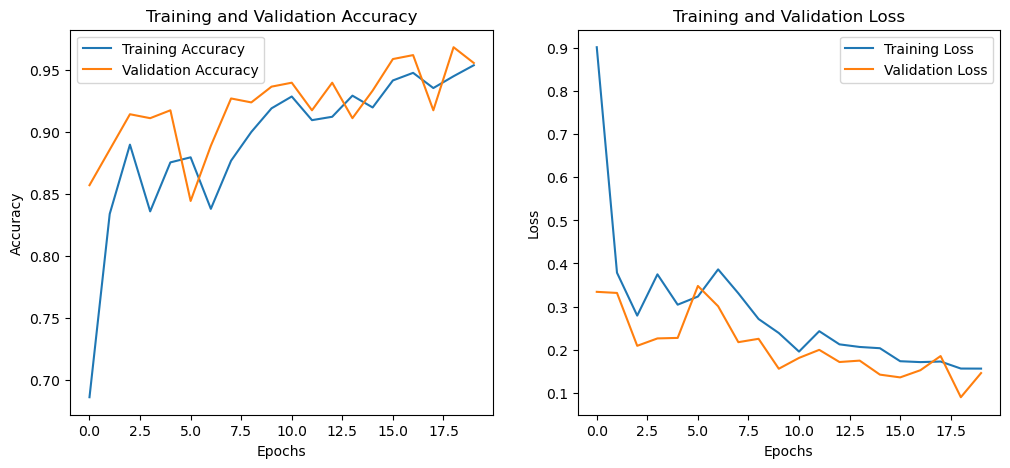

In [ ]:
# training vs val accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

The model seems to have trained well. The bumps in the graph are possibly during the class imbalance of the dataset.

To understand the model's true performance, it must be tested on unseen data. This can be done by using the model to classify the testing set of data reserved earlier and analyzing its scores on certain evaluation metrics.

In [ ]:
# Generate predictions for the test set and converting to binary labels
test_predictions = model.predict(test_generator)
test_predictions = (test_predictions > 0.5).astype(int).flatten()

# Extract true labels from the test generator
true_labels = test_generator.classes  # Actual labels from the generator

accuracy = accuracy_score(true_labels, test_predictions)
precision = precision_score(true_labels, test_predictions)
recall = recall_score(true_labels, test_predictions)
f1 = f1_score(true_labels, test_predictions)


# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")



10/10 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step
Accuracy: 0.96
Precision: 0.93
Recall: 0.94
F1 Score: 0.94


The model is showing strong results for the above evaluation metrics. In our case, Recall is a specifically crucial metric. It expresses how many of the actual positive cases were correctly classified ie, how many of the actual TB positive cases the model was able to classify. A high recall score is important, since missing a TB-positive case could have serious consequences!

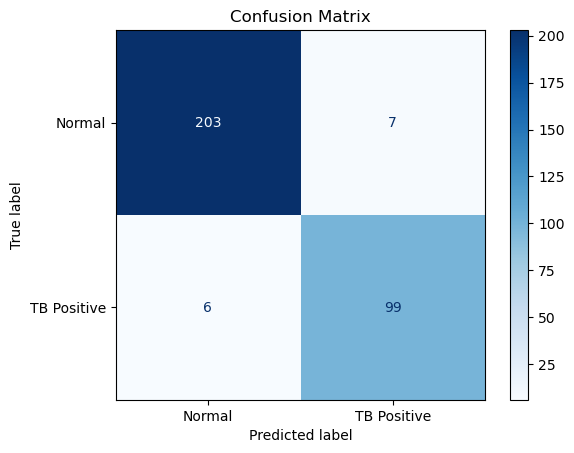

In [ ]:
# Confusion Matrix
cm = confusion_matrix(true_labels, test_predictions)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "TB Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

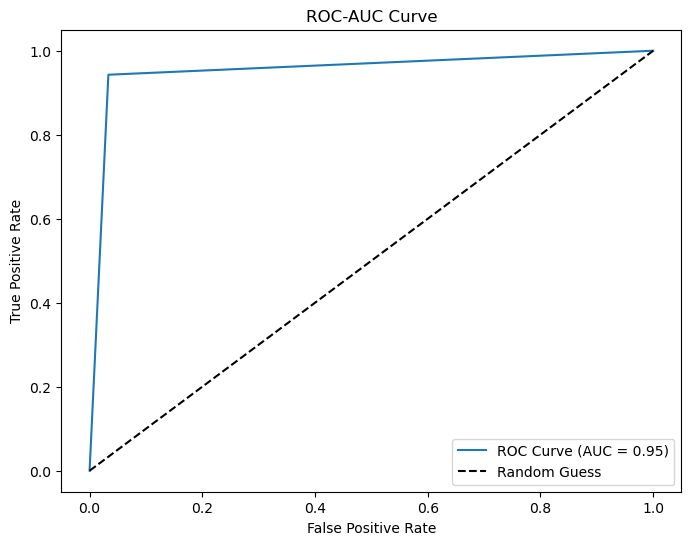

In [ ]:
# Calculate ROC-AUC
roc_auc = roc_auc_score(true_labels, test_predictions)

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, test_predictions)

# Plot ROC-AUC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve')
plt.legend(loc='best')
plt.show()


The above drawn Confusion Matrix and ROC curve together give more confidence the model's ability to perform well on new unseen data.

Finally, I conclude with a working model that is classifying with an accuracy of 96% to determine the presence of Tuberculosis within a given chest X-ray image. While this project programmatically deals with the lack of publically accessible data, a larger dataset with the right computing resources strongly presents future scope for the project that can help increase the generalizability and sturdiness of the model even further.